In [ ]:
!unzip '/content/archive (11).zip'

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

In [ ]:
train_data_dir = '/content/Alzheimer_s Dataset/train'
test_data_dir = '/content/Alzheimer_s Dataset/test'

### IMPORT LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### IMPORT / VIEWING / PREPROCESSING DATASET

> `DATA AUGMENTATION`

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:17<00:00,  3.51s/it]


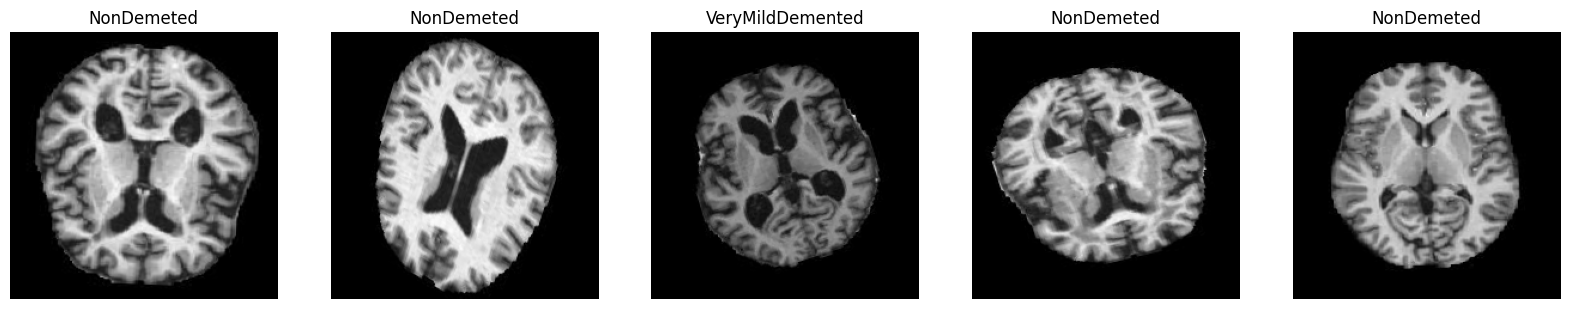

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('MildDemented')
    elif a[1] == 1:
        ax[i].set_title('ModerateDemented')
    elif a[2] == 1:
        ax[i].set_title('NonDemeted')
    elif a[3] == 1:
        ax[i].set_title('VeryMildDemented')

### MODEL BUILDING

---



In [ ]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3),
                         include_top=False,
                         weights="imagenet")

51877672/51877672 [==============================] - 1s 0us/step


In [ ]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [ ]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (Batch  (None, 81536)             326144    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                       

In [ ]:
# Model Compile

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [ ]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
33/33 [==============================] - ETA: 0s - loss: 1.3450 - auc: 0.7910 
Epoch 1: val_auc improved from -inf to 0.69909, saving model to ./best_weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 1373s 41s/step - loss: 1.3450 - auc: 0.7910 - val_loss: 5.4237 - val_auc: 0.6991
Epoch 2/10
33/33 [==============================] - ETA: 0s - loss: 1.0718 - auc: 0.8356 
Epoch 2: val_auc improved from 0.69909 to 0.71963, saving model to ./best_weights.hdf5
33/33 [==============================] - 1364s 41s/step - loss: 1.0718 - auc: 0.8356 - val_loss: 2.5231 - val_auc: 0.7196
Epoch 3/10
33/33 [==============================] - ETA: 0s - loss: 1.0003 - auc: 0.8462 
Epoch 3: val_auc improved from 0.71963 to 0.76162, saving model to ./best_weights.hdf5
33/33 [==============================] - 1359s 41s/step - loss: 1.0003 - auc: 0.8462 - val_loss: 1.7376 - val_auc: 0.7616
Epoch 4/10
33/33 [==============================] - ETA: 0s - loss: 0.9738 - auc: 0.8524 
Epoch 4: val_auc improved from 0.76162 to 0.76515, saving model to ./best_weights.hdf5
33/33 [==============================] - 1376s 42s/step - loss: 0.9738 - auc: 0.8524 - val_loss: 1.6775

### MODEL EVALUATION

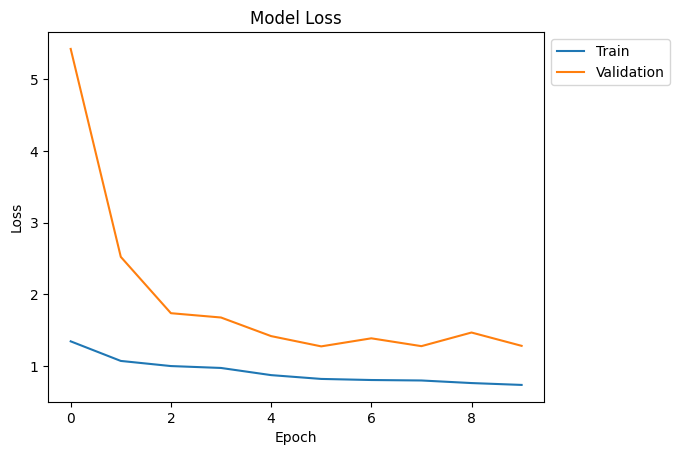

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

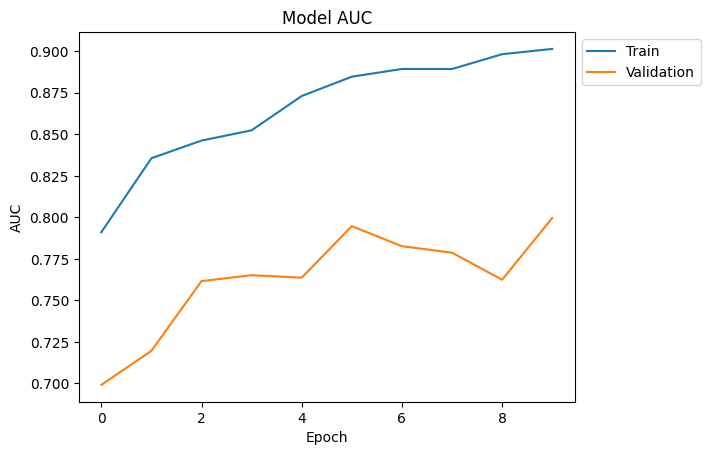

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
# Test Data

test_dataset  = test_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


In [ ]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 297s 29s/step - loss: 1.0717 - auc: 0.8530


[1.0716747045516968, 0.8529987335205078]

In [ ]:
from keras.models import Model

In [ ]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model = load_model('/content/model.h5')

In [ ]:
answer = model.predict(img)

1/1 [==============================] - 4s 4s/step


In [ ]:
class_label = np.argmax(answer)

In [ ]:
class_name = idc[class_label]

In [ ]:
probability = round(np.max(answer)*100,2)
print(probability, '% chances are there that the image is', class_name)

48.12 % chances are there that the image is NonDemented


1/1 [==============================] - 4s 4s/step
48.12 % chances are there that the image is NonDemented


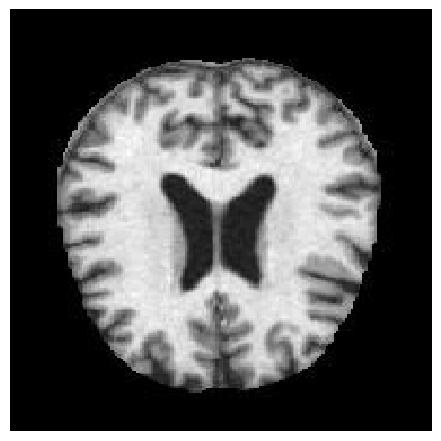

In [ ]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/test/NonDemented/26 (69).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

# Load the model
model = load_model('/content/model.h5')

# Predict the class
answer = model.predict(img)

# Extract the class label and name
class_label = np.argmax(answer)
class_name = idc[class_label]

# Calculate and print the probability
probability = round(np.max(answer)*100,2)
print(probability, '% chances are there that the image is', class_name)

1/1 [==============================] - 5s 5s/step
69.94 % chances are there that the image is MildDemented


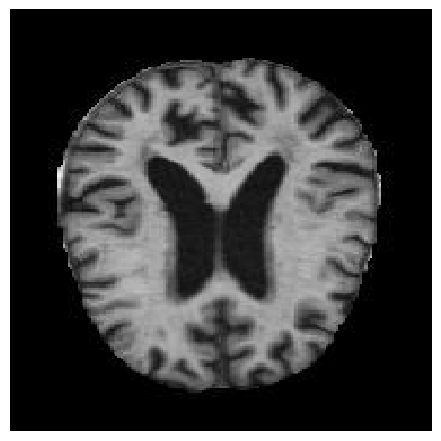

In [ ]:
# Test Case 2: MildDemented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/test/MildDemented/26 (23).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

# Load the model
model = load_model('/content/model.h5')

# Predict the class
answer = model.predict(img)

# Extract the class label and name
class_label = np.argmax(answer)
class_name = idc[class_label]

# Calculate and print the probability
probability = round(np.max(answer)*100,2)
print(probability, '% chances are there that the image is', class_name)

1/1 [==============================] - 4s 4s/step
43.13 % chances are there that the image is MildDemented


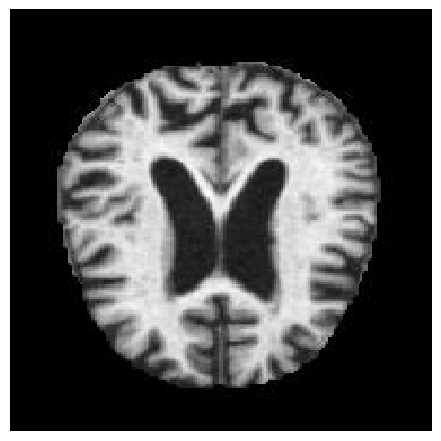

In [ ]:
# Test Case 3: ModerateDemented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/test/ModerateDemented/29 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

# Load the model
model = load_model('/content/model.h5')

# Predict the class
answer = model.predict(img)

# Extract the class label and name
class_label = np.argmax(answer)
class_name = idc[class_label]

# Calculate and print the probability
probability = round(np.max(answer)*100,2)
print(probability, '% chances are there that the image is', class_name)

1/1 [==============================] - 4s 4s/step
86.88 % chances are there that the image is NonDemented


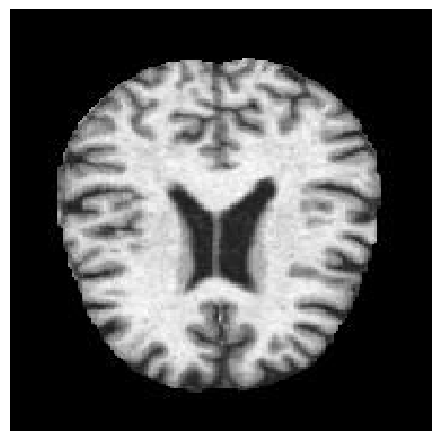

In [ ]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/test/VeryMildDemented/26 (49).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

# Load the model
model = load_model('/content/model.h5')

# Predict the class
answer = model.predict(img)

# Extract the class label and name
class_label = np.argmax(answer)
class_name = idc[class_label]

# Calculate and print the probability
probability = round(np.max(answer)*100,2)
print(probability, '% chances are there that the image is', class_name)

Conclusion:

So, we have finally built are deep learning model using DenseNet162 transfer learning algorithm and acheived and AUC-90%.